In [225]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [227]:
import tonic
import torchvision

sensor_size = tonic.datasets.NMNIST.sensor_size
frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, time_window=1000)

trainset = tonic.datasets.NMNIST(save_to="./data", train=True)
testset = tonic.datasets.NMNIST(
    save_to="./data", transform=frame_transform, train=False
)



In [229]:
events = trainset[0][0]
events

array([(10, 30,    937, 1), (33, 20,   1030, 1), (12, 27,   1052, 1), ...,
       ( 7, 15, 302706, 1), (26, 11, 303852, 1), (11, 17, 305341, 1)],
      dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')])

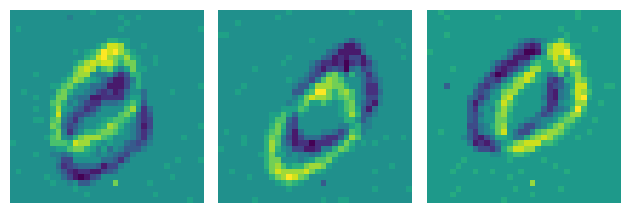

In [231]:
tonic.utils.plot_event_grid(events)

In [233]:
trainset[0][1]

0

In [235]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self,
        input_features,
        hidden_features,
        output_features,
        tau_syn_inv,
        tau_mem_inv,
        record=False,
        dt=1e-3,
    ):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(
                alpha=100,
                v_th=torch.as_tensor(0.3),
                tau_syn_inv=tau_syn_inv,
                tau_mem_inv=tau_mem_inv,
            ),
            dt=dt,
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

In [237]:
example_snn = SNN(
    np.product(trainset.sensor_size),
    100,
    len(trainset.classes),
    tau_syn_inv=torch.tensor(1 / 1e-2),
    tau_mem_inv=torch.tensor(1 / 1e-2),
    record=True,
    dt=1e-3,
)

frames, target = next(iter(train_loader))

frames[:, :1].shape

torch.Size([311, 1, 2, 34, 34])

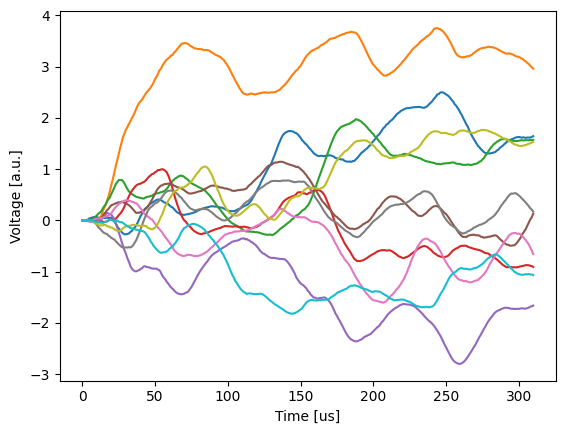

In [239]:
example_readout_voltages = example_snn(frames[:, :1])
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [us]")
plt.show()

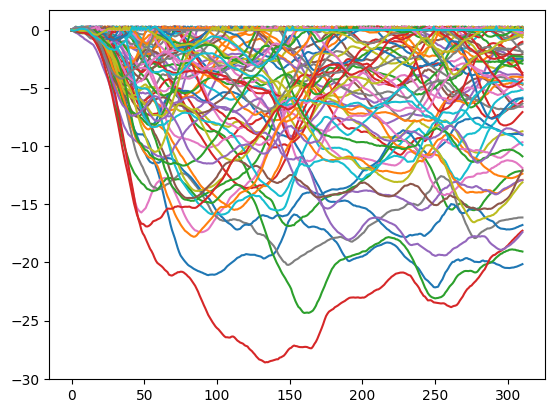

In [241]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

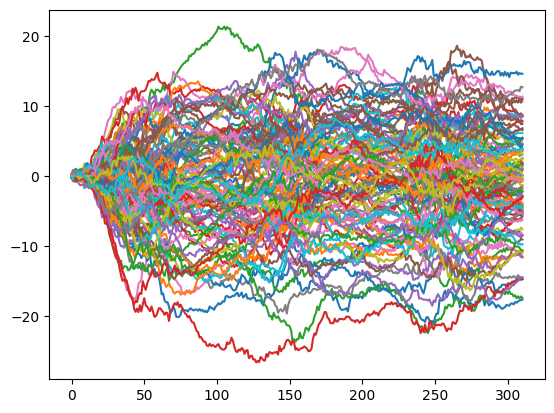

In [243]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

Final accuracy: 95.78%

Anmerkung: Ausführungszeit = 4 Stunden

In [247]:
import torch
from tqdm.notebook import tqdm
import numpy as np
import tonic


In [249]:
# Hyperparameter
BATCH_SIZE = 32
LR = 0.002
HIDDEN_FEATURES = 100
EPOCHS = 60

# Setze Sparse-Transformation für den Trainingsdatensatz
trainset.transform = frame_transform

# DataLoader erstellen
def create_data_loader(dataset, batch_size, shuffle=False):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=tonic.collation.PadTensors(batch_first=False),
        shuffle=shuffle,
    )

train_loader = create_data_loader(trainset, BATCH_SIZE, shuffle=True)
test_loader = create_data_loader(testset, BATCH_SIZE)


In [251]:
# Decoder-Funktion
def decode(x):
    return torch.nn.functional.log_softmax(torch.max(x, 0)[0], dim=1)


In [253]:
# Modellklasse
class Model(torch.nn.Module):
    def __init__(self, snn):
        super(Model, self).__init__()
        self.snn = snn

    def forward(self, x):
        return decode(self.snn(x))


In [255]:
# Gerät auswählen
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modell initialisieren
INPUT_FEATURES = np.product(trainset.sensor_size)
OUTPUT_FEATURES = len(trainset.classes)

model = Model(
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
        tau_syn_inv=torch.tensor(1 / 1e-2),
        tau_mem_inv=torch.tensor(1 / 1e-2),
    )
).to(DEVICE)


In [257]:
# Optimierer initialisieren
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [259]:
def train_epoch(model, device, train_loader, optimizer):
    model.train()  # Setze das Modell in den Trainingsmodus
    correct = 0  # Zähler für korrekte Vorhersagen
    total = 0  # Zähler für alle Beispiele
    running_loss = 0.0  # Summe des Verlusts
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)  # Lade Daten auf das richtige Gerät
        optimizer.zero_grad()  # Setze die Gradienten des Optimierers zurück
        output = model(data)  # Modellvorhersage
        
        loss = torch.nn.functional.nll_loss(output, target)  # Verlustberechnung
        loss.backward()  # Berechne Gradienten
        optimizer.step()  # Optimierer-Update
        
        running_loss += loss.item()  # Akkumulieren des Verlusts
        _, predicted = output.max(1)  # Hole die Vorhersage (Index mit maximaler Wahrscheinlichkeit)
        total += target.size(0)  # Gesamtzahl der Beispiele im Batch
        correct += (predicted == target).sum().item()  # Zähle korrekte Vorhersagen
    
    train_accuracy = 100.0 * correct / total  # Berechne die Genauigkeit
    return running_loss / len(train_loader), train_accuracy  # Rückgabe des Verlusts und der Genauigkeit



def test_epoch(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients during validation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = torch.nn.functional.nll_loss(output, target, reduction="sum")
            total_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    average_loss = total_loss / len(test_loader.dataset)
    accuracy = 100.0 * correct / total
    return average_loss, accuracy


In [261]:
# Definiere Listen zum Speichern der Verluste und Genauigkeiten
training_losses, mean_losses, test_losses, accuracies = [], [], [], []

# Hyperparameter für Early Stopping
patience = 10  # Anzahl der Epochen ohne Verbesserung des Testverlustes, um das Training zu stoppen
best_test_loss = float('inf')  # Bestmöglicher Testverlust zu Beginn
epochs_without_improvement = 0  # Zähler für Epochen ohne Verbesserung

for epoch in range(EPOCHS):
    print(f"Starting Epoch {epoch + 1}/{EPOCHS}")
    
    # Trainingsphase
    training_loss, training_accuracy = train_epoch(model, DEVICE, train_loader, optimizer)
    
    # Testphase
    test_loss, test_accuracy = test_epoch(model, DEVICE, test_loader)
    
    # Record losses and accuracies
     # Record losses and accuracies
    training_losses.append(training_loss)
    mean_losses.append(training_loss)  
    test_losses.append(test_loss)
    accuracies.append(test_accuracy)
    
    # Frühzeitiges Stoppen: Wenn sich der Testverlust nicht verbessert
    if test_loss < best_test_loss:
        best_test_loss = test_loss  # Testverlust aktualisieren
        epochs_without_improvement = 0  # Zähler zurücksetzen
        
        # Speichern des Modells, wenn der Testverlust verbessert wird
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss,
        }, 'best_model.pth')  # Bestes Modell speichern
        print(f"Model saved at epoch {epoch + 1} with test loss: {test_loss:.4f}")
        
    else:
        epochs_without_improvement += 1
    
    # Wenn in 'patience' Epochen keine Verbesserung eintritt, Training stoppen
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. Test loss hasn't improved for {patience} epochs.")
        break
    
    # Fortschritt anzeigen
    print(f"Epoch {epoch + 1}/{EPOCHS} - "
          f"Train Loss: {training_loss:.4f}, "
          f"Train Accuracy: {training_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test Accuracy: {test_accuracy:.2f}%")
    
# Endgültige Metriken ausgeben
print(f"Final Test Accuracy: {accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.2f}%")


Starting Epoch 1/60
Model saved at epoch 1 with test loss: 0.2866
Epoch 1/60 - Train Loss: 0.4887, Train Accuracy: 84.95%, Test Loss: 0.2866, Test Accuracy: 91.18%
Starting Epoch 2/60
Model saved at epoch 2 with test loss: 0.2396
Epoch 2/60 - Train Loss: 0.2595, Train Accuracy: 92.24%, Test Loss: 0.2396, Test Accuracy: 92.70%
Starting Epoch 3/60
Model saved at epoch 3 with test loss: 0.1949
Epoch 3/60 - Train Loss: 0.2102, Train Accuracy: 93.65%, Test Loss: 0.1949, Test Accuracy: 93.92%
Starting Epoch 4/60
Model saved at epoch 4 with test loss: 0.1650
Epoch 4/60 - Train Loss: 0.1889, Train Accuracy: 94.33%, Test Loss: 0.1650, Test Accuracy: 94.71%
Starting Epoch 5/60
Epoch 5/60 - Train Loss: 0.1739, Train Accuracy: 94.80%, Test Loss: 0.2096, Test Accuracy: 93.78%
Starting Epoch 6/60
Model saved at epoch 6 with test loss: 0.1637
Epoch 6/60 - Train Loss: 0.1550, Train Accuracy: 95.28%, Test Loss: 0.1637, Test Accuracy: 95.08%
Starting Epoch 7/60
Model saved at epoch 7 with test loss: 0.1

IndexError: list index out of range

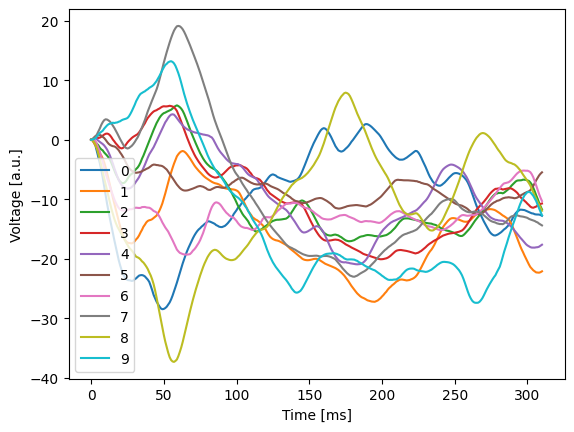

In [263]:
# Start 19:48 --> 60 Epochen --> Ende 06:20 = 8 Stunden 30 Minuten

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_snn = model.snn.to(DEVICE)
frames = frames.to(DEVICE)

# Hier gehen wir davon aus, dass 'frames' mehrere Eingabebeispiele enthalten kann.
trained_readout_voltages = trained_snn(frames[:, :1])  # Nur das erste Beispiel (falls frames mehr als eines enthält)

# Um die Spannung zu plotten, holen wir die Daten von der GPU und konvertieren sie zu NumPy
voltages = trained_readout_voltages.squeeze(1).cpu().detach().numpy()

# Falls mehrere Klassen oder Kanäle vorhanden sind, iteriere durch sie
for i in range(voltages.shape[1]):  # Annahme: Zweite Dimension entspricht den Klassen/Kanälen
    plt.plot(voltages[:, i], label=f"{i}")

# Achsenbeschriftung
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")

# Legende anzeigen
plt.legend()

# Plot anzeigen
plt.show()


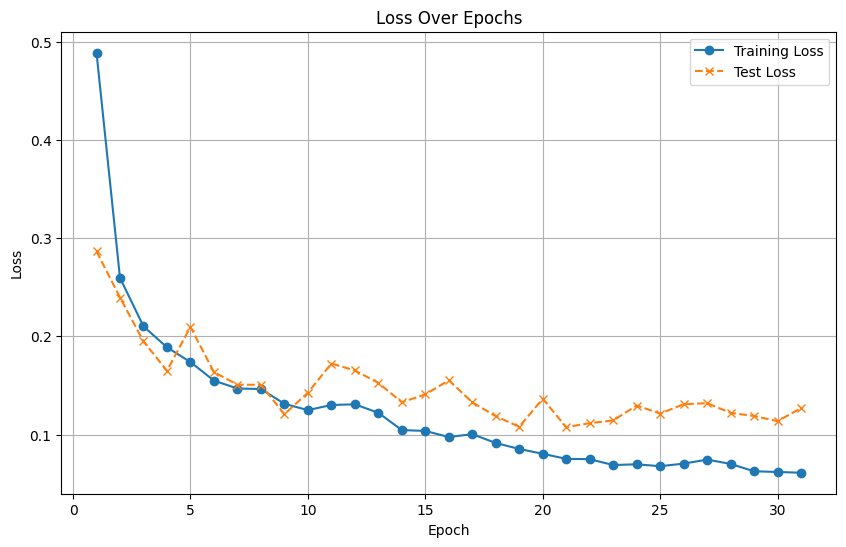

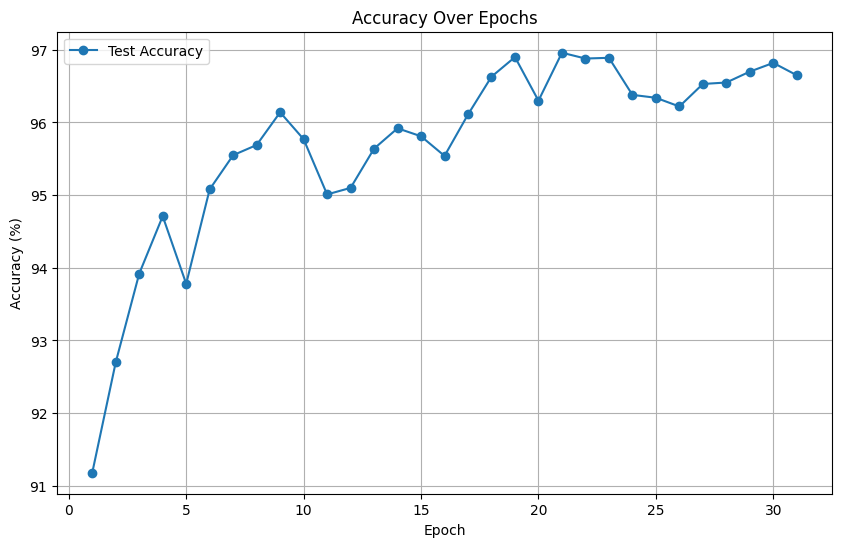

In [265]:
import matplotlib.pyplot as plt

# Beispiel-Daten (ersetzen Sie diese mit Ihren Listen)
epochs = range(1, len(mean_losses) + 1)

# Plot für Verluste
plt.figure(figsize=(10, 6))
plt.plot(epochs, mean_losses, label="Training Loss", marker="o", linestyle="-")
plt.plot(epochs, test_losses, label="Test Loss", marker="x", linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot für Genauigkeiten
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, label="Test Accuracy", marker="o", linestyle="-")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [211]:
# Definiere Listen zum Speichern der Verluste und Genauigkeiten
training_losses, mean_losses, test_losses, accuracies = [], [], [], []

# Hyperparameter für Early Stopping
patience = 10  # Anzahl der Epochen ohne Verbesserung des Testverlustes, um das Training zu stoppen
best_test_loss = float('inf')  # Bestmöglicher Testverlust zu Beginn
epochs_without_improvement = 0  # Zähler für Epochen ohne Verbesserung

for epoch in range(EPOCHS):
    print(f"Starting Epoch {epoch + 1}/{EPOCHS}")
    
    # Trainingsphase
    training_loss, training_accuracy = train_epoch(model, DEVICE, train_loader, optimizer)
    
    # Testphase
    test_loss, test_accuracy = test_epoch(model, DEVICE, test_loader)
    
    # Record losses and accuracies
     # Record losses and accuracies
    training_losses.append(training_loss)
    mean_losses.append(training_loss)  
    test_losses.append(test_loss)
    accuracies.append(test_accuracy)
    
    # Frühzeitiges Stoppen: Wenn sich der Testverlust nicht verbessert
    if test_loss < best_test_loss:
        best_test_loss = test_loss  # Testverlust aktualisieren
        epochs_without_improvement = 0  # Zähler zurücksetzen
        
        # Speichern des Modells, wenn der Testverlust verbessert wird
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss,
        }, 'best_model.pth')  # Bestes Modell speichern
        print(f"Model saved at epoch {epoch + 1} with test loss: {test_loss:.4f}")
        
    else:
        epochs_without_improvement += 1
    
    # Wenn in 'patience' Epochen keine Verbesserung eintritt, Training stoppen
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. Test loss hasn't improved for {patience} epochs.")
        break
    
    # Fortschritt anzeigen
    print(f"Epoch {epoch + 1}/{EPOCHS} - "
          f"Train Loss: {training_loss:.4f}, "
          f"Train Accuracy: {training_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test Accuracy: {test_accuracy:.2f}%")
    
# Endgültige Metriken ausgeben
print(f"Final Test Accuracy: {accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.2f}%")


Starting Epoch 1/60
Epoch 1/60 - Train Loss: 0.1491, Train Accuracy: 95.53%, Test Loss: 0.1596, Test Accuracy: 95.16%
Starting Epoch 2/60


KeyboardInterrupt: 

In [215]:
import torch

# Hyperparameter für Early Stopping
patience = 10  # Anzahl der Epochen ohne Verbesserung des Testverlustes, um das Training zu stoppen
best_test_loss = float('inf')  # Bestmöglicher Testverlust zu Beginn
epochs_without_improvement = 0  # Zähler für Epochen ohne Verbesserung

# Definiere Listen zum Speichern der Verluste und Genauigkeiten
training_losses, mean_losses, test_losses, accuracies = [], [], [], []
validation_losses, validation_accuracies = [], []

for epoch in range(EPOCHS):
    print(f"Starting Epoch {epoch + 1}/{EPOCHS}")
    
    # Trainingsphase
    training_loss, training_accuracy = train_epoch(model, DEVICE, train_loader, optimizer)
    
    # Testphase
    test_loss, test_accuracy = test_epoch(model, DEVICE, test_loader)
    
    # Record losses and accuracies
    training_losses.append(training_loss)
    mean_losses.append(training_loss)  # Oder eine andere Metrik, die du bevorzugst
    test_losses.append(test_loss)
    accuracies.append(test_accuracy)
    
    # Frühzeitiges Stoppen: Wenn sich der Testverlust nicht verbessert
    if test_loss < best_test_loss:
        best_test_loss = test_loss  # Testverlust aktualisieren
        epochs_without_improvement = 0  # Zähler zurücksetzen
        
        # Speichern des Modells, wenn der Testverlust verbessert wird
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss,
        }, 'best_model.pth')  # Bestes Modell speichern
        print(f"Model saved at epoch {epoch + 1} with test loss: {test_loss:.4f}")
        
    else:
        epochs_without_improvement += 1
    
    # Wenn in 'patience' Epochen keine Verbesserung eintritt, Training stoppen
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. Test loss hasn't improved for {patience} epochs.")
        break
    
    # Fortschritt anzeigen
    print(f"Epoch {epoch + 1}/{EPOCHS} - "
          f"Train Loss: {training_loss:.4f}, "
          f"Train Accuracy: {training_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test Accuracy: {test_accuracy:.2f}%")
    
# Endgültige Metriken ausgeben
print(f"Final Test Accuracy: {accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.2f}%")


Starting Epoch 1/60
Model saved at epoch 1 with test loss: 0.1526
Epoch 1/60 - Train Loss: 0.1444, Train Accuracy: 95.72%, Test Loss: 0.1526, Test Accuracy: 95.32%
Starting Epoch 2/60
Epoch 2/60 - Train Loss: 0.1268, Train Accuracy: 96.23%, Test Loss: 0.1662, Test Accuracy: 95.26%
Starting Epoch 3/60
Epoch 3/60 - Train Loss: 0.1305, Train Accuracy: 96.02%, Test Loss: 0.1622, Test Accuracy: 95.27%
Starting Epoch 4/60
Model saved at epoch 4 with test loss: 0.1376
Epoch 4/60 - Train Loss: 0.1342, Train Accuracy: 95.96%, Test Loss: 0.1376, Test Accuracy: 96.13%
Starting Epoch 5/60
Epoch 5/60 - Train Loss: 0.1166, Train Accuracy: 96.44%, Test Loss: 0.1392, Test Accuracy: 95.81%
Starting Epoch 6/60
Model saved at epoch 6 with test loss: 0.1251
Epoch 6/60 - Train Loss: 0.1139, Train Accuracy: 96.57%, Test Loss: 0.1251, Test Accuracy: 96.24%
Starting Epoch 7/60
Epoch 7/60 - Train Loss: 0.1151, Train Accuracy: 96.48%, Test Loss: 0.1336, Test Accuracy: 95.97%
Starting Epoch 8/60
Epoch 8/60 - Tra

IndexError: list index out of range